In [1]:
import pickle
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import minimize, NonlinearConstraint, LinearConstraint, Bounds
import seaborn as sns
import cvxpy as cp
import numpy as np
import pandas as pd
## latex for matplotlib
from matplotlib import rc

# activate latex text rendering
rc('text', usetex=True)

In [2]:

def cvxpy_nias(p_m_x_given_u, act_prob, act_sels, priors, margin_niac, margin_nias):
  """
  Formulates the NIAS constraints in CVXPY notation.

  Args:
    p_m_x_given_u: A 3D NumPy array representing the conditional probabilities
      p_m(x|u). The dimensions of the array should be (M, X, A), where M is the
      number of elements in set M, X is the number of elements in set X, and A
      is the number of elements in set U.
    margin_nias: The margin value for the NIAS constraint.

  Returns:
    A list of CVXPY constraints representing the NIAS inequalities.
  """

  # Extract dimensions
  M, X, A = p_m_x_given_u.shape
  r_m_u_x = cp.Variable((M*X*A+M, 1))

  # Create decision variable with shape (M*X*A, 1)
  

  # Constraints
  constraints = []

  # NIAS constraint
  for m in range(M):
    for u in range(A):
      for u_prime in range(A):
        if u != u_prime:  # Add condition to exclude u == u_prime
          nias_expr = 0
          for x in range(X):
            index = m*X*A + x*A + u
            index_prime = m*X*A + x*A + u_prime
            nias_expr += p_m_x_given_u[m, x, u] * (r_m_u_x[index_prime] - r_m_u_x[index])
          constraints.append(nias_expr + margin_nias <= 0)  # Add margin_nias here



  # NIAC constraint
  for m1 in range(M):
    for m2 in range(M):
      if m1 != m2:
        niac_expr = 0
        for u in range(A):
          max_term = -np.inf
          for u_prime in range(A):
            term = 0
            for x in range(X):
              index = m1*X*A + x*A + u_prime
              term += act_sels[m2][x, u] * priors[m2][x] / act_prob[m2][u] * r_m_u_x[index]
            max_term = cp.maximum(max_term, term) - r_m_u_x[M*X*A+m2]
          niac_expr += act_prob[m1][u] * max_term

          for x in range(X):
            index = m1*X*A + x*A + u
            niac_expr -= p_m_x_given_u[m1, x, u] * act_prob[m1][u] * r_m_u_x[index] 
          niac_expr -=  r_m_u_x[M*X*A+m1]
  constraints.append(niac_expr + margin_niac <= 0)  # Add margin_niac here
  constraints.append(r_m_u_x>=0)
  objective = cp.Minimize(cp.norm1(r_m_u_x[:M*X*A]))
  problem = cp.Problem(objective, constraints)
  problem.solve()
  return r_m_u_x.value


In [3]:



# Example usage:
# Assuming 
M = 4
X = 5
A = 5
p_m_x_given_u = np.concatenate([np.eye(X)+np.random.uniform(0,1,size=(X,X)) for i in range(M)]).reshape(M,X,X)
# p_m_x_given_u/p_m_x_given_u.sum(axis=2)


# Example usage:
# ... (Set up p_m_x_given_u, act_prob, act_sels, priors as needed)

margin_nias = 11
margin_niac =22

actsels_prob = p_m_x_given_u/p_m_x_given_u.sum(axis=2).reshape(M,A,1)
actsels = actsels_prob
priors = np.ones((M,X))/X

act_probs_by_category = {}
num_actions = actsels_prob.shape[-1]

for categ in range(M): # parametrizes the prior
  act_probs_by_category[categ] = []
  for action in range(num_actions):
    # compute p(a) = prior*p(a|x)
    act_probs_by_category[categ].append(priors[categ,:]@actsels_prob[categ,:,action])
    # compute p(x|a) = p(a|x)*prior/p(a)

  act_probs_by_category[categ] = np.array(act_probs_by_category[categ])


r_sparse = cvxpy_nias(p_m_x_given_u, act_probs_by_category, actsels, priors, margin_niac, margin_nias)

# Combine constraints and solve the problem


# ... (Access the optimal value and r_m_u_x.value)


Error: rescode.err_invalid_cj(1474): The value of the c elementforvariablet '' (280) is invalid.


In [4]:
def cvxpy_nias_margin(p_m_x_given_u, act_prob, act_sels, priors,solver=cp.CLARABEL):
  """
  Formulates the NIAS constraints in CVXPY notation.

  Args:
    p_m_x_given_u: A 3D NumPy array representing the conditional probabilities
      p_m(x|u). The dimensions of the array should be (M, X, A), where M is the
      number of elements in set M, X is the number of elements in set X, and A
      is the number of elements in set U.

  Returns:
    A list of CVXPY constraints representing the NIAS inequalities.
  """

  # Extract dimensions
  M, X, A = p_m_x_given_u.shape
  r_m_u_x = cp.Variable((M*X*A+M+2, 1))

  # Create decision variable with shape (M*X*A, 1)
  

  # Constraints
  constraints = []

  # NIAS constraint
  for m in range(M):
    for u in range(A):
      for u_prime in range(A):
        if u != u_prime:  # Add condition to exclude u == u_prime
          nias_expr = 0
          for x in range(X):
            index = m*X*A + x*A + u
            index_prime = m*X*A + x*A + u_prime
            nias_expr += p_m_x_given_u[m, x, u] * (r_m_u_x[index_prime] - r_m_u_x[index])
          constraints.append(nias_expr  + r_m_u_x[-1] <= 0)  # Add margin_nias here



  # NIAC constraint
  for m1 in range(M):
    for m2 in range(M):
      if m1 != m2:
        niac_expr = 0
        for u in range(A):
          max_term = -np.inf
          for u_prime in range(A):
            term = 0
            for x in range(X):
              index = m1*X*A + x*A + u_prime
              term += act_sels[m2][x, u] * priors[m2][x] / act_prob[m2][u] * r_m_u_x[index]
            max_term = cp.maximum(max_term, term) - r_m_u_x[M*X*A+m2]
          niac_expr += act_prob[m1][u] * max_term

          for x in range(X):
            index = m1*X*A + x*A + u
            niac_expr -= p_m_x_given_u[m1, x, u] * act_prob[m1][u] * r_m_u_x[index] 
          niac_expr -=  r_m_u_x[M*X*A+m1]
        constraints.append(niac_expr + r_m_u_x[-2] <= 0)  # Add margin_niac here

  constraints.append(r_m_u_x>=0)
  constraints.append(r_m_u_x[-1]<=10)
  constraints.append(r_m_u_x[-2]<=10)
  objective = cp.Maximize(r_m_u_x[-1]+r_m_u_x[-2])
  problem = cp.Problem(objective, constraints)
  problem.solve(verbose=True, solver=solver)
  return r_m_u_x.value
M = 4
X = 5
A = 5
p_m_x_given_u = np.concatenate([np.eye(X)+np.random.uniform(0,1,size=(X,X)) for i in range(M)]).reshape(M,X,X)
# p_m_x_given_u/p_m_x_given_u.sum(axis=2)


# Example usage:
# ... (Set up p_m_x_given_u, act_prob, act_sels, priors as needed)


actsels_prob = p_m_x_given_u/p_m_x_given_u.sum(axis=2).reshape(M,A,1)
actsels = actsels_prob
priors = np.ones((M,X))/X

act_probs_by_category = {}
num_actions = actsels_prob.shape[-1]

for categ in range(M): # parametrizes the prior
  act_probs_by_category[categ] = []
  for action in range(num_actions):
    # compute p(a) = prior*p(a|x)
    act_probs_by_category[categ].append(priors[categ,:]@actsels_prob[categ,:,action])
    # compute p(x|a) = p(a|x)*prior/p(a)

  act_probs_by_category[categ] = np.array(act_probs_by_category[categ])


r = cvxpy_nias_margin(p_m_x_given_u, act_probs_by_category, actsels, priors)


                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Nov 01 11:31:17 PM: Your problem has 106 variables, 200 constraints, and 0 parameters.
(CVXPY) Nov 01 11:31:17 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 01 11:31:17 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 01 11:31:17 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 01 11:31:17 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 01 11:31:17 PM: Compiling problem (target solver=CLARABEL

In [196]:
df = pd.read_csv("./data/output_csv_cleaned.csv") 


In [203]:
convert_to_int_from_binary_list = lambda x: np.argwhere(x[:5]==1)[-1][0]+1 if x[:5].sum() > 0  else 0

In [204]:
df['action'] = df.iloc[:,1:].apply(lambda x: convert_to_int_from_binary_list(x), axis=1)

In [205]:
M = 2
X = 6
A = 6
p_m_x_given_u = np.zeros((M,X,A))
for x in range(X):
    for a in range(A):
        p_m_x_given_u[0,x,a] = df[['state','action']].groupby('state').apply(lambda x: (x['action']==a).mean(),include_groups=False)[x]
        # p_m_x_given_u[1,x,a] = df[['state','action'][:120]].groupby('state').apply(lambda x: (x['action']==a).mean())

In [207]:
p_m_x_given_u[1,:,:] = p_m_x_given_u[0,:,:]  + np.random.uniform(0,0.01,size=(X,A))

In [208]:
p_m_x_given_u[1,:,:] = p_m_x_given_u[1,:,:]/p_m_x_given_u[1,:,:].sum(axis=1).reshape(X,1)

In [218]:
actsels_prob = p_m_x_given_u/p_m_x_given_u.sum(axis=2).reshape(M,X,1)
actsels = actsels_prob
priors = np.ones((M,X))/X

act_probs_by_category = {}
num_actions = actsels_prob.shape[-1]

for categ in range(M): # parametrizes the prior
  act_probs_by_category[categ] = []
  for action in range(num_actions):
    # compute p(a) = prior*p(a|x)
    act_probs_by_category[categ].append(priors[categ,:]@actsels_prob[categ,:,action])
    # compute p(x|a) = p(a|x)*prior/p(a)

  act_probs_by_category[categ] = np.array(act_probs_by_category[categ])


r = cvxpy_nias_margin(p_m_x_given_u, act_probs_by_category, actsels, priors)


                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Oct 16 10:21:14 AM: Your problem has 76 variables, 140 constraints, and 0 parameters.
(CVXPY) Oct 16 10:21:14 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 16 10:21:14 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 16 10:21:14 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Oct 16 10:21:14 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 16 10:21:14 AM: Compiling problem (target solver=CLARABEL)

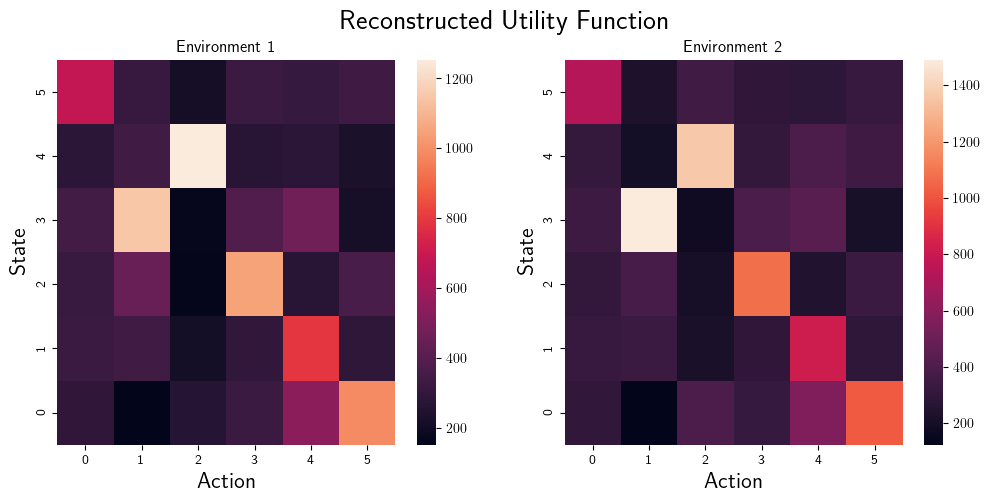

In [216]:
fig,axs = plt.subplots(1,2,figsize=(12,5))
plt.suptitle("Reconstructed Utility Function",size=20)
for i in range(M):
    sns.heatmap(r[i*X*A:(i+1)*X*A].reshape(X,A),ax=axs[i%2])
    axs[i%2].set_title(f"Environment {i+1}")
    axs[i%2].set_xlabel("Action",size=16)
    axs[i%2].set_ylabel("State",size=16)
    axs[i%2].set_yticklabels(range(X)[::-1])
plt.savefig("plots/utility_function.pdf",bbox_inches='tight')

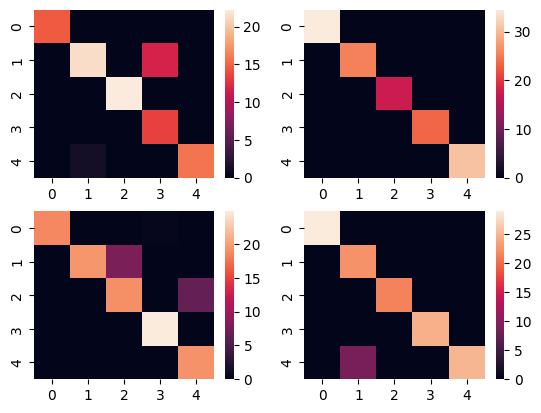

In [52]:
fig,axs = plt.subplots(2,2)
for i in range(M):
    sns.heatmap(r_sparse[i*X*A:(i+1)*X*A].reshape(X,A),ax=axs[i%2,i//2])

In [5]:
products_good = pd.read_csv('data/good_product_data.csv')
products_good['state'] = True
products_bad = pd.read_csv('data/bad_product_data.csv') 
products_bad['state'] = False

In [6]:
products = pd.concat([products_good,products_bad]).reset_index(drop=True)

In [7]:
products = products[['state','overall','defects','durability','expectations','recommend']]

In [8]:
products['state']

0        True
1        True
2        True
3        True
4        True
        ...  
2706    False
2707    False
2708    False
2709    False
2710    False
Name: state, Length: 2711, dtype: bool

In [9]:
products['action'] = products.apply(lambda x:4*(x['durability'])+2*(x['expectations'])+(x['recommend']),axis=1)

In [10]:
M = 5
X = 2
A = 8
p_m_x_given_u = np.zeros((M,X,A))
for m in range(M):
    for x in range(X):
        for a in range(A):
            p_m_x_given_u[m,x,a] = products[(products['overall']==m+1)&(products['state']==x)].reset_index()['action'].apply(lambda y: y==a).mean()
print(p_m_x_given_u.sum(axis=2))

[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]


In [11]:
p_m_x_given_u+=1e-3
p_m_x_given_u = p_m_x_given_u/p_m_x_given_u.sum(axis=2).reshape(M,X,1)

In [12]:
actsels_prob = p_m_x_given_u/p_m_x_given_u.sum(axis=2).reshape(M,X,1)
actsels = actsels_prob
priors = np.ones((M,X))/X

act_probs_by_category = {}
num_actions = actsels_prob.shape[-1]

for categ in range(M): # parametrizes the prior
  act_probs_by_category[categ] = []
  for action in range(num_actions):
    # compute p(a) = prior*p(a|x)
    act_probs_by_category[categ].append(priors[categ,:]@actsels_prob[categ,:,action])
    # compute p(x|a) = p(a|x)*prior/p(a)

  act_probs_by_category[categ] = np.array(act_probs_by_category[categ])


r = cvxpy_nias_margin(p_m_x_given_u, act_probs_by_category, actsels, priors,solver=cp.CLARABEL)

                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Nov 01 11:32:33 PM: Your problem has 87 variables, 389 constraints, and 0 parameters.
(CVXPY) Nov 01 11:32:33 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 01 11:32:33 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 01 11:32:33 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 01 11:32:33 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 01 11:32:33 PM: Compiling problem (target solver=CLARABEL)

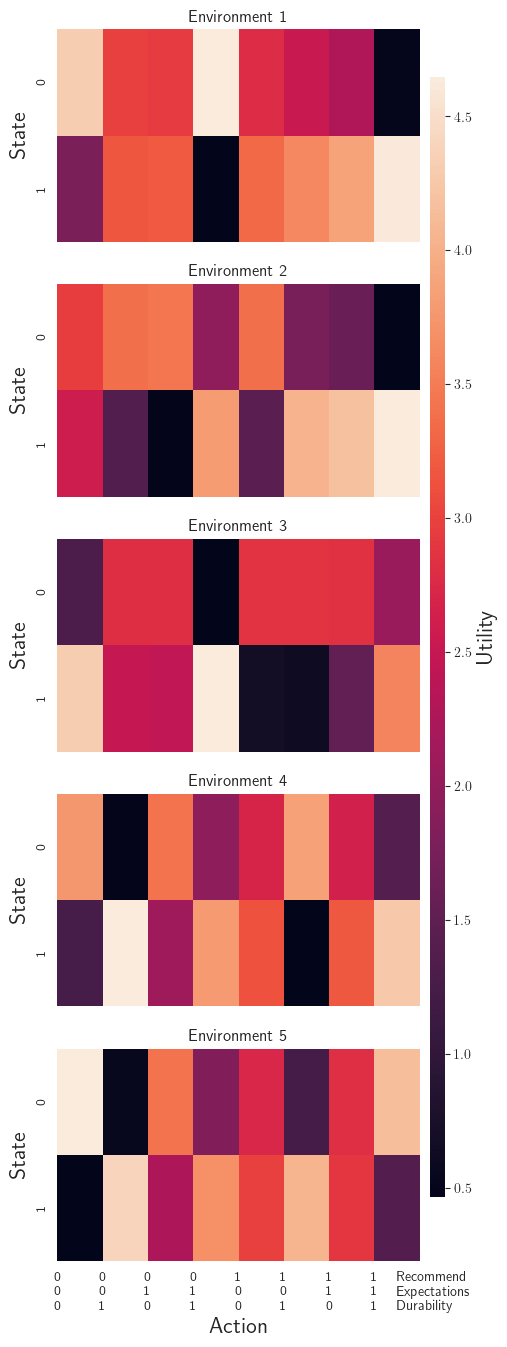

In [14]:
sns.set_style("darkgrid")

fig,axs = plt.subplots(M,1,figsize=(5,16))
## common colorbar
import matplotlib
matplotlib.rcParams.update({'text.usetex': True})
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])

for i in range(M):
    sns.heatmap(r[i*X*A:(i+1)*X*A].reshape(X,A),ax=axs[i],cbar=True,cbar_ax=cbar_ax)
    axs[i].set_title(f"Environment {i+1}")
    axs[i].set_xlabel("")
    # axs[i].set_title(f"Environment {i+1}")
    # axs[i].set_xlabel("Action",size=16)
    axs[i].set_ylabel("State",size=16)
    axs[i].set_xticks([])
    # axs[i].set_yticklabels(range(X)[::-1])
cbar_ax.set_ylabel("Utility",size=16)
axs[-1].set_xlabel("Action",size=16)
def generate_binary_sequence(bits=3):
    binary_numbers = []
    for i in range(2**bits):
        binary = format(i, f'0{bits}b')
        # Stack digits vertically using newlines
        stacked = '\n'.join(binary)
        binary_numbers.append(stacked)
    return binary_numbers
binary_labels = generate_binary_sequence()
axs[-1].set_xticks(np.arange(A),binary_labels)
axs[-1].text(7.5,2.18,"Recommend",fontsize=10)
axs[-1].text(7.5,2.32,"Expectations",fontsize=10)
axs[-1].text(7.5,2.46,"Durability",fontsize=10)
plt.savefig("plots/utility_function_product.pdf",bbox_inches='tight')

In [400]:
import torch
import torch.nn as nn
import torch.optim as optim
import cvxpy as cp



def cvxpy_nias_constraint_value(r_m_u_x,p_m_x_given_u, act_prob, act_sels, priors):
  """
  Formulates the NIAS constraints in CVXPY notation.

  Args:
    p_m_x_given_u: A 3D NumPy array representing the conditional probabilities
      p_m(x|u). The dimensions of the array should be (M, X, A), where M is the
      number of elements in set M, X is the number of elements in set X, and A
      is the number of elements in set U.
    margin_nias: The margin value for the NIAS constraint.

  Returns:
    A list of CVXPY constraints representing the NIAS inequalities.
  """

  # Extract dimensions
  M, X, A = p_m_x_given_u.shape
  # r_m_u_x = torch.concat([r_m_u_x[:M*X*A,0],r_m_u_x[:M,1]])
  # Create decision variable with shape (M*X*A, 1)
  
  margin_niac = r_m_u_x[M+1,1]
  margin_nias = r_m_u_x[M+2,1]
  # Constraints
  constraints = torch.zeros(1,requires_grad=True)

  # NIAS constraint
  for m in range(M):
    for u in range(A):
      for u_prime in range(A):
        if u != u_prime:  # Add condition to exclude u == u_prime
          nias_expr = torch.zeros(1,requires_grad=True)
          for x in range(X):
            index = m*X*A + x*A + u
            index_prime = m*X*A + x*A + u_prime
            nias_expr = nias_expr+ p_m_x_given_u[m, x, u] * (r_m_u_x[index_prime,0] - r_m_u_x[index,0])
          constraints = constraints + nias_expr + margin_nias  # Add margin_nias here



 
  # NIAC constraint
  for m1 in range(M):
    for m2 in range(M):
      if m1 != m2:
        niac_expr = torch.zeros(1,requires_grad=True)
        for u in range(A):
          max_term = -torch.tensor(np.inf,requires_grad=True).reshape(1)
          for u_prime in range(A):
            term = torch.zeros(1,requires_grad=True)
            for x in range(X):
              index = m1*X*A + x*A + u_prime
              term =term + act_sels[m2][x, u] * priors[m2][x] / act_prob[m2][u] * r_m_u_x[index,0]

            max_term = torch.max(max_term, term) - r_m_u_x[m2,1]
            
          niac_expr = niac_expr+ act_prob[m1][u] * max_term

          for x in range(X):
            index = m1*X*A + x*A + u
            niac_expr = niac_expr + p_m_x_given_u[m1, x, u] * act_prob[m1][u] * r_m_u_x[index,0] 
          niac_expr = niac_expr -  r_m_u_x[m1,1]
        constraints = constraints + niac_expr + margin_niac  # Add margin_niac here
  # constraints.append(r_m_u_x>=0)
  return constraints


class UtilityNetwork(nn.Module):
    def __init__(self, num_states, num_actions,num_env, hidden_dim=20):
        super(UtilityNetwork, self).__init__()
        self.fc1 = nn.Linear(num_states + num_actions+num_env, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 2)

    def forward(self, env,state, action):
        x = torch.cat((env,state, action), dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

def train_utility_network(model, p_m_x_given_u, act_prob, act_sels, priors, 
                          learning_rate=1e-3, epochs=1000,lagrange_multiplier=10):
    """
    Trains the utility network with the given constraints.

    Args:
      model: The UtilityNetwork model.
      p_m_x_given_u: A 3D NumPy array representing the conditional probabilities
        p_m(x|u).
      act_prob: A dictionary where keys are categories (m) and values are 1D NumPy
        arrays representing action probabilities p_m(u).
      act_sels: A dictionary where keys are categories (m) and values are 2D NumPy
        arrays representing action selections p_m(u|x).
      priors: A dictionary where keys are categories (m) and values are 1D NumPy
        arrays representing prior probabilities p(x).
      margin_niac: The margin value for the NIAC constraint.
      margin_nias: The margin value for the NIAS constraint.
      learning_rate: The learning rate for the optimizer.
      epochs: The number of epochs to train for.
    """

    M, X, A = p_m_x_given_u.shape
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    env_state_action_pairs = torch.zeros((M*X*A, M+X+A))
    for env in range(M):
      for state in range(X):
          for action in range(A):
              env_state_action_pairs[env*A*X+state*A + action] = torch.cat([torch.eye(M)[env],torch.eye(X)[state], torch.eye(A)[action]])
    
    for epoch in range(epochs):
        
        optimizer.zero_grad()
        # Predict utilities
        utilities = model(env_state_action_pairs[:, :M],env_state_action_pairs[:, M:M+X], env_state_action_pairs[:, M+X:])
        # CVXPY optimization with Lagrange multipliers
        constraint_value = cvxpy_nias_constraint_value(utilities,p_m_x_given_u, act_prob, act_sels, priors)
        
        # Calculate loss and gradients
        loss = torch.relu(1-utilities[M+1,1])+torch.relu(1-utilities[M+2,1]) + torch.relu(constraint_value)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
            print(f'Constraint value: {constraint_value.item()}')
            print(f'Utilities: {torch.norm(utilities[:,0])}')
            print(f'Margins: {utilities[M+1:M+3,1]}')
    return utilities
# Example usage:
# ... (Set up p_m_x_given_u, act_prob, act_sels, priors as needed)

# num_states = 4  # Example number of states
# num_actions = 3  # Example number of actions
# num_env = 2
num_env,num_states,num_actions = p_m_x_given_u.shape
model = UtilityNetwork(num_states, num_actions,num_env)
utilities = train_utility_network(model, p_m_x_given_u, act_probs_by_category, actsels, priors, 
                     learning_rate=1e-4, epochs=1000,lagrange_multiplier=.5)

Epoch [1/1000], Loss: 2.1634
Constraint value: -7.111413478851318
Utilities: 2.5308187007904053
Margins: tensor([-0.0200, -0.1434], grad_fn=<SelectBackward0>)
Epoch [101/1000], Loss: 1.9561
Constraint value: -1.8017317056655884
Utilities: 2.6109864711761475
Margins: tensor([ 0.0761, -0.0322], grad_fn=<SelectBackward0>)
Epoch [201/1000], Loss: 1.8624
Constraint value: -0.006348460912704468
Utilities: 2.705778121948242
Margins: tensor([0.1270, 0.0106], grad_fn=<SelectBackward0>)
Epoch [301/1000], Loss: 1.8307
Constraint value: -0.0029495954513549805
Utilities: 2.7879130840301514
Margins: tensor([0.1513, 0.0180], grad_fn=<SelectBackward0>)
Epoch [401/1000], Loss: 1.8020
Constraint value: -0.03649872541427612
Utilities: 2.8676371574401855
Margins: tensor([0.1740, 0.0239], grad_fn=<SelectBackward0>)
Epoch [501/1000], Loss: 1.7739
Constraint value: -0.06850624084472656
Utilities: 2.9489848613739014
Margins: tensor([0.1965, 0.0296], grad_fn=<SelectBackward0>)
Epoch [601/1000], Loss: 1.7439
Co

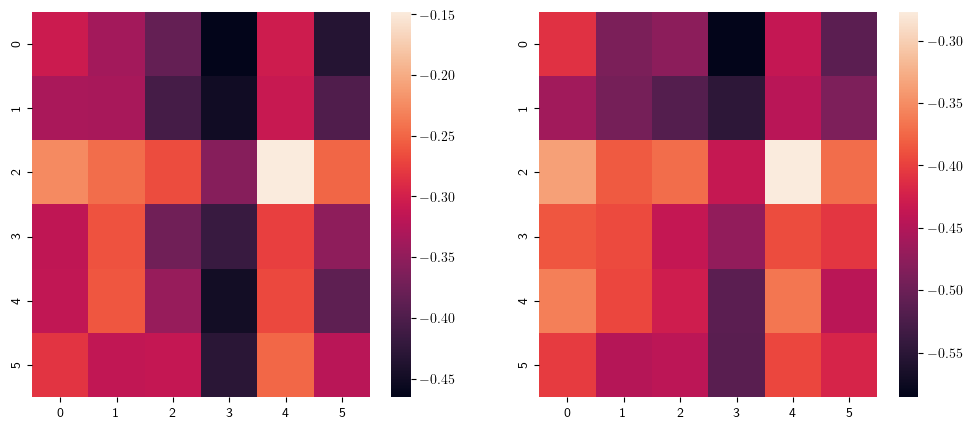

In [401]:
fig,axs = plt.subplots(1,2,figsize=(12,5))
r_neural = utilities[:,0].detach().numpy()
for i in range(M):
    sns.heatmap(r_neural[i*X*A:(i+1)*X*A].reshape(X,A),ax=axs[i%2])

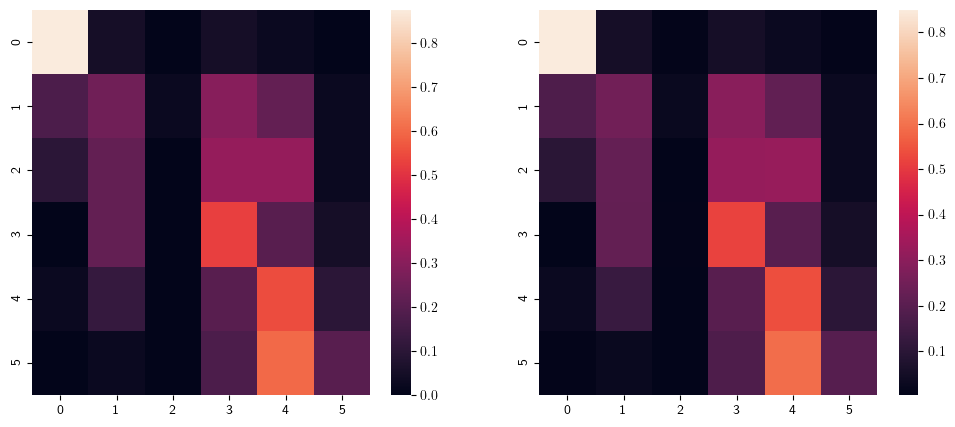

In [399]:
fig,axs = plt.subplots(1,2,figsize=(12,5))

r_true = p_m_x_given_u.reshape(M*X*A,1)
for i in range(M):
    sns.heatmap(r_true[i*X*A:(i+1)*X*A].reshape(X,A),ax=axs[i%2])
    